# TED Talks Recommender System

In this notebook, we will build a very basic content-based Machine Learning recommender system that can recommend TED talks based on the topics of your interest.

## Content Based Recommender Systems

A Content-Based Recommender works by the data that we take from the user, either explicitly (rating) or implicitly (clicking on a link). 
From the data we create a user profile, which is then used to suggest content to the user; as the user provides more input or takes more actions on the recommendation, the engine becomes more accurate.

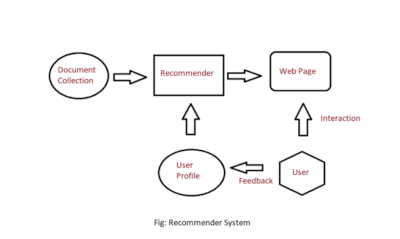

*User Profile:*
In the User Profile, we create vectors that describe the user’s preference. 
In the creation of a user profile, we use the utility matrix which describes the relationship between user and item. 
With this information, the best estimate we can make regarding which item user likes, is some aggregation of the profiles of those items.

*Item Profile:*
In Content-Based Recommender, we must build a profile for each item, which will represent the important characteristics of that item.
For example, if we make a movie as an item then its actors, director, release year and genre are the most significant features of the movie. 
We can also add its rating from the IMDB (Internet Movie Database) in the Item Profile.

*Utility Matrix:*
Utility Matrix signifies the user's preference with certain items. 
In the data gathered from the user, we have to find some relation between the items which are liked by the user and those which are disliked, for this purpose we use the utility matrix. 
In it we assign a particular value to each user-item pair, this value is known as the degree of preference. 
Then we draw a matrix of a user with the respective items to identify their preference relationship.

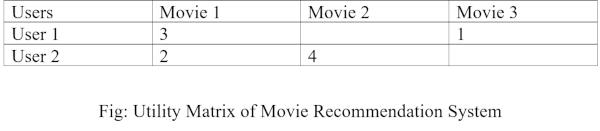

Some of the columns are blank in the matrix that is because we don't get the whole input from the user every time, and the goal of a recommendation system is not to fill all the columns but to recommend a movie to the user which he/she will prefer. 
Through this table, our recommender system won't suggest Movie 3 to User 2, because in Movie 1 they have given approximately the same ratings, and in Movie 3 User 1 has given the low rating, so it is highly possible that User 2 also won't like it.

## Recommending Items to User Based on Content:

- Method 1:
    We can use the cosine distance between the vectors of the item and the user to determine its preference to the user. Let us consider an example:
    We observe that the vector for a user will have a positive number for actors that tend to appear in movies the user likes and negative numbers for actors user doesn’t like, Consider a movie with actors which user likes and only a few actors which user doesn’t like, then the cosine angle between the user’s and movie’s vectors will be a large positive fraction. Thus, the angle will be close to 0, therefore a small cosine distance between the vectors.
    It represents that the user tends to like the movie, if the cosine distance is large, then we tend to avoid the item from the recommendation.
- Method 2:
    We can use a classification approach in the recommendation systems too, e.g. we can use a Decision Tree for finding out whether a user wants to watch a movie or not.
    With this approach, at each level we can apply a certain condition to refine our recommendation. For example:

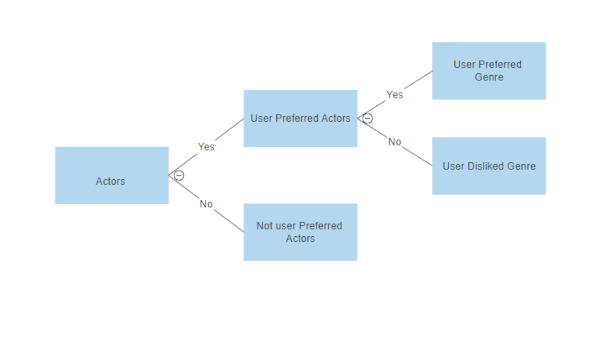

# Import Libraries

We will use the following Python Libraries:

1. [Pandas](https://pandas.pydata.org/): This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.
2. [Numpy](https://numpy.org/): Numpy arrays are very fast and can perform large computations in a very short time.
3. [matplotlib](https://matplotlib.org/) / [Wordcloud](https://pypi.org/project/wordcloud/): These libraries are used to draw visualizations.
4. [nltk](https://www.nltk.org/): This NLP library is used to perform text processing on the raw text data.


In [1]:
%pip install -Uqq pandas numpy matplotlib wordcloud nltk

In [2]:
%%capture
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import string
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
warnings.filterwarnings('ignore')

The [TEDx Dataset](https://www.kaggle.com/mauropelucchi/tedx-talk?select=tedx_dataset.csv) we will use contains information about audio-video recordings of 4,467 TED Talks in the span of years 2006 – 2018, uploaded to the official TED.com website.
It can be obtained from Kaggle at: "https://www.kaggle.com/mauropelucchi/tedx-talk?select=tedx_dataset.csv". I've downloaded it and it's in the Datasets directory.

In [3]:
ds_path = Path("Datasets","TEDx-Talks-Dataset","tedx_dataset.csv")
df = pd.read_csv(ds_path)
print(df.head())

                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

The _tedx_dataset.csv_ file contains the main information about TED talks including an unique id, the title, the main speaker, the number of views, a summary and the url.

In [4]:
df.shape

(4467, 7)

Now let’s check if there are null values present in the dataset.

In [5]:
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

We can see that almost 95% of the data is missing from the `num_views` columns so, we won’t be able to derive any insights from this column of the data.

In [6]:
splitted = df['posted'].str.split(' ', expand=True)

# Create columns for month and year of each talk
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

Now let’s check what is the trend in the number of TED talks happening yearly.

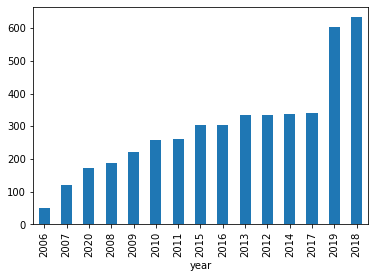

In [7]:
df['year'].value_counts(ascending=True).plot.bar()
plt.show()

We can see an approximately increasing trend in the number of ted talks released on the yearly basis except for some exceptions.

In [8]:
# Combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['details']

# Remove the unnecessary information
df = df[['main_speaker', 'details']]
df.dropna(inplace = True)
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


In [9]:
# Make a copy of our data for future use.
data = df.copy()

## Text Preprocessing

In general data we obtained in the form of raw text requires a lot of preprocessing before it can be used to develop any model. 
Removal of stopwords, stemming, lemmatization, and removing punctuations are some steps that help us to convert the raw textual data into a usable format.

In [10]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    # Store the important words
    for word in str(text).split(): word = word.lower()
    if word not in stop_words: imp_words.append(word)
    output = " ".join(imp_words)

    return output

Now, let’s use the above helper function to remove the stopwords present in our data.

In [11]:
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,details
0,Alexandra Auer,common.
1,Elizabeth Gilbert,2020)
2,Butterscotch,says.
3,Ethan Lisi,spectrum.
4,Daniel Finkel,anderson].


Now, we will remove any punctuations present in the data.

In [12]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)

df['details'] = df['details'].apply(lambda x: cleaning_punctuations(x))
df.head()

,main_speaker,details
0,Alexandra Auer,common
1,Elizabeth Gilbert,2020
2,Butterscotch,says
3,Ethan Lisi,spectrum
4,Daniel Finkel,anderson


`wordcloud` is a visualization tool that helps us to visualize the occurrence of words, i.e. which are the words that are more frequent in our text corpus.

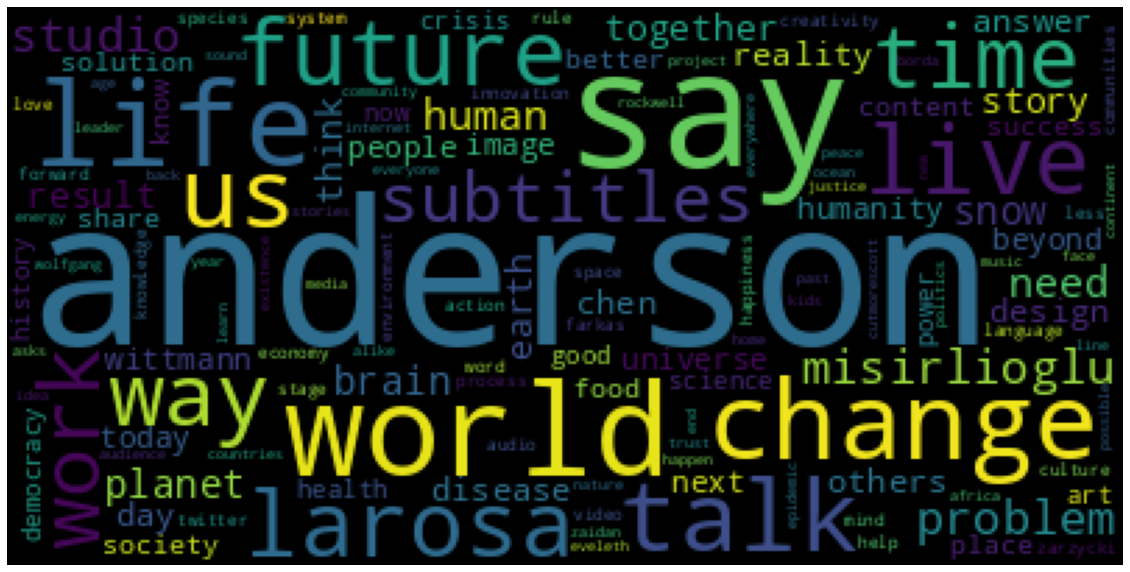

In [14]:
details_corpus = " ".join(df['details'])

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=400, height=200).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

From the above word cloud, we can observe that words like _world, time, future, life, change_ are some of the most frequent words. This seems aligned with the objective of TED talks which is to help this world through the experiences of some successful people.

## Recommender System

As the details are all that we have about the talks we will use them to build our recommender system. 
We will use the __Tf-IDF__ vectorizer to convert our textual data into their numerical representations.

In [15]:
%%capture
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

We will use _Cosine Similarity_ as the indicator to measure the similarity between our data and the input by the user. Cosine Similarity is a measure of similarity between two non-zero vectors defined in an inner product space. In practice, cosine similarity is the cosine of the angle between the two vectors; that is, it is the Euclidean dot product of the vectors divided by the product of their lengths. It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle. The cosine similarity always belongs to the interval [-1,1].

In [16]:
def get_similarities(talk_content, data):

    # Get vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()
    
    # We will store similarity for each row of the dataset.
    sim = []
    for idx, row in data.iterrows():
        details = row['details']

        # Get vector for current talk.
        talk_array2 = vectorizer.transform(data[data['details'] == details]['details']).toarray()
        # Calculate cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
        sim.append(cos_sim)

    return sim

The function below will call the above helper function to get the similarity between the input and the data of the talk we have.

In [17]:
def recommend_talks(talk_content, data):

    data['cos_sim'] = get_similarities(talk_content, data)
    data.sort_values(by=['cos_sim'], ascending=False, inplace=True)
    display(data[['main_speaker', 'details']].head())

Now, it’s time to see the recommender system at work. Let’s see which talks are recommended by the system based on some common topics.

In [18]:
talk_content = ['Time Management and working hard to become successful in life.']
recommend_talks(talk_content, df)

,main_speaker,details
3763,John Kasaona,working
2745,Rodrigo Canales,management
4204,Martin Seligman,become
3613,Martin Jacques,become
3752,Charles Leadbeater,become


Let’s look at one more example.

In [19]:
talk_content = ['Climate change and impact on the health. How can we change this world by reducing carbon footprints?']
recommend_talks(talk_content, df)

,main_speaker,details
1197,Robin Steinberg,change
646,T. Morgan Dixon and Vanessa Garrison,change
1258,Simone Bianco and Tom Zimmerman,change
1125,Heidi M. Sosik,change
3216,Dalia Mogahed,change
